# Video Game Hit Predictor: Point 5 Evaluation
1. Setup, Data Loading, and Leakage Prevention
We start by importing all necessary libraries for data handling, model training, and evaluation. We then load the pre-processed cleaned_dataset.csv.

Crucially, we drop Global_Sales and Unnamed: 0 to prevent data leakage, as the Is_hit target variable was created directly from Global_Sales.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import necessary sklearn and XGBoost modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, RocCurveDisplay
)
from sklearn.dummy import DummyClassifier

In [2]:
# --- 1. SETUP AND DATA LOADING ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import necessary sklearn and XGBoost modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, RocCurveDisplay
)
from sklearn.dummy import DummyClassifier

# Load the cleaned dataset (output of Point 2)
# NOTE: The file 'cleaned_dataset.csv' must be in the same directory.
try:
    df = pd.read_csv('cleaned_dataset.csv')
    print("Dataset loaded successfully. Shape:", df.shape)
except FileNotFoundError:
    print("Error: 'cleaned_dataset.csv' not found. Please check file path.")


# --- 2. DATA SPLIT AND LEAKAGE PREVENTION ---

# Drop Global_Sales, Is_hit (target), and any residual index column
X = df.drop(columns=['Is_hit', 'Global_Sales', 'Unnamed: 0'], errors='ignore')
y = df['Is_hit']

# Split the data into training (70%) and testing (30%) sets.
# We use stratify=y to ensure the 90/10 Hit/Flop ratio is maintained in both sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("\nData Split Complete (70/30).")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Dataset loaded successfully. Shape: (16540, 37)

Data Split Complete (70/30).
X_test shape: (4962, 35), y_test shape: (4962,)


### 2. Model Training (Integration of Point 4)
We define and train the three models using the same configurations and class-weighting strategy established in the training phase. This step is necessary to ensure the evaluation in the next cells uses freshly trained models based on the 70% training split defined above.

The scale_pos_weight is calculated to penalize the misclassification of the minority class (Hits), counteracting the 90/10 class imbalance.

In [3]:
# --- 3. MODEL DEFINITION AND TRAINING (INTEGRATING POINT 4) ---

# Calculate Class Weight for XGBoost (Ratio of Flops to Hits)
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"\nCalculated scale_pos_weight: {scale_pos_weight:.2f}")

models = {
    "Logistic Regression": LogisticRegression(
        class_weight='balanced', max_iter=10000, random_state=1
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=300, max_depth=12, min_samples_leaf=5,
        class_weight='balanced', random_state=1
    ),
    "XGBoost": XGBClassifier(
        scale_pos_weight=scale_pos_weight, n_estimators=500, max_depth=7,
        learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, 
        eval_metric='logloss', random_state=1, use_label_encoder=False
    )
}

trained_models = {}

# Training Loop
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    trained_models[name] = model
    print(f"Done.")


Calculated scale_pos_weight: 9.02
Training Logistic Regression...
Done.
Training Random Forest...
Done.
Training XGBoost...


c:\Users\Vig88\Documents\GitHub\Ai-game-predictions\.venv\lib\site-packages\xgboost\training.py:199: UserWarning: [11:53:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Done.


### 3. Evaluation Function Definition and Baseline
The evaluate_model function formalizes the process of calculating metrics. Since our business goal is to identify Hits, the F1_Score, Precision, and Recall are calculated specifically for the positive class (pos_label=1).

We also define the Dummy Classifier baseline, which predicts the majority class (Flop) every time.

In [7]:
# --- 4. EVALUATION FUNCTION DEFINITION ---

def evaluate_model(model, X_test, y_test, model_name='Model'):
    """
    Calculates and returns all required classification metrics, focusing on the Hit class (1).
    """
    y_pred = model.predict(X_test)
    
    # Calculate required metrics, using zero_division=0 to handle the Dummy case
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        # F1, Precision, and Recall focus on the positive class (1=Hit)
        'F1_Score': f1_score(y_test, y_pred, average='binary', pos_label=1, zero_division=0),
        'Precision': precision_score(y_test, y_pred, average='binary', pos_label=1, zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='binary', pos_label=1, zero_division=0),
    }
    
    # Calculate AUC-ROC score (requires probability scores)
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
        metrics['ROC_AUC'] = roc_auc_score(y_test, y_proba)
    except (AttributeError, ValueError):
        # Handle models like DummyClassifier that lack predict_proba
        metrics['ROC_AUC'] = np.nan 
    
    metrics['Training_Time_s'] = np.nan # Placeholder for actual training time

    return metrics, y_pred


# --- 5. MODEL Filled with Trained Models ---

# A. MANDATORY BASELINE: Dummy Classifier
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train, y_train)

models_to_evaluate = {
    "Dummy Classifier": dummy_clf,
    "Logistic Regression": trained_models["Logistic Regression"],
    "Random Forest": trained_models["Random Forest"],
    "XGBoost": trained_models["XGBoost"]
}

### 4. Execution, Comparison, and Export
We execute the evaluation function for all models, track the one with the highest F1-Score (our primary metric), and create the final comparison table. This table is printed to the console (using Markdown for easy report copy-paste) and exported as a CSV file.

In [8]:
# --- 6. EXECUTION: RUN EVALUATION AND COMPARISON SETUP ---

results_list = []
best_model_name = ""
best_f1 = -1
best_y_pred = None

for name, model in models_to_evaluate.items():
    if model is not None:
        print(f"\nEvaluating: {name}...")
        metrics, y_pred = evaluate_model(model, X_test, y_test, name)
        results_list.append(metrics)
        
        # Track the best model based on F1 Score
        if metrics['F1_Score'] > best_f1:
            best_f1 = metrics['F1_Score']
            best_model_name = name
            best_y_pred = y_pred

# Create the final comparison DataFrame
comparison_df = pd.DataFrame(results_list).set_index('Model').sort_values(by='F1_Score', ascending=False)
comparison_df = comparison_df[['F1_Score', 'ROC_AUC', 'Precision', 'Recall', 'Accuracy', 'Training_Time_s']]

print("\n" + "="*50)
print("FINAL MODEL COMPARISON TABLE (Point 5.2)")
print("="*50)
print(comparison_df.to_markdown())
print(f"\nBest Model by F1-Score: {best_model_name}")

# Export to CSV for report appendix/sharing
comparison_df.to_csv('model_comparison_results.csv')


Evaluating: Dummy Classifier...

Evaluating: Logistic Regression...

Evaluating: Random Forest...

Evaluating: XGBoost...

FINAL MODEL COMPARISON TABLE (Point 5.2)
| Model               |   F1_Score |   ROC_AUC |   Precision |   Recall |   Accuracy |   Training_Time_s |
|:--------------------|-----------:|----------:|------------:|---------:|-----------:|------------------:|
| XGBoost             |   0.367374 |  0.793303 |    0.273445 | 0.559596 |   0.807739 |               nan |
| Random Forest       |   0.318141 |  0.770281 |    0.204246 | 0.719192 |   0.692463 |               nan |
| Logistic Regression |   0.266465 |  0.704801 |    0.16395  | 0.711111 |   0.609432 |               nan |
| Dummy Classifier    |   0        |  0.5      |    0        | 0        |   0.900242 |               nan |

Best Model by F1-Score: XGBoost


### 5. Visualization Generation
Finally, we generate three key plots for the best-performing model (based on F1-Score) to be included in the final report:

Confusion Matrix: Shows the breakdown of correct and incorrect predictions.

ROC Curve: Illustrates the model's ability to discriminate between classes across all probability thresholds.

Feature Importance: Essential for tree-based models (RF/XGBoost) to explain why the model made its decisions.

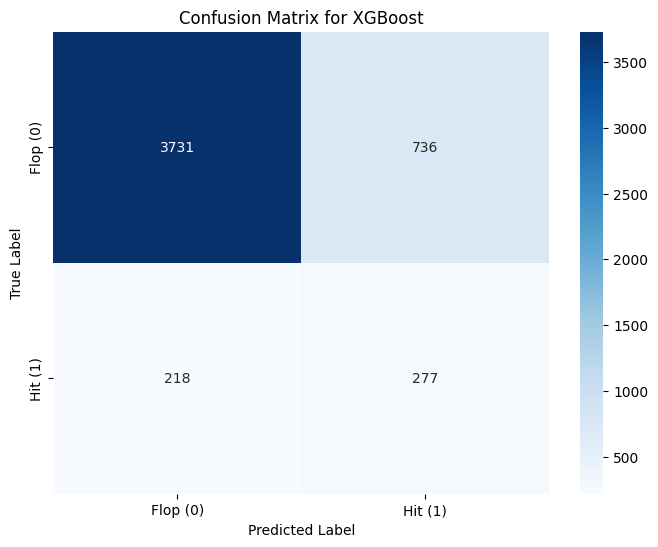


Confusion Matrix plot saved as 'confusion_matrix.png'.


<Figure size 800x600 with 0 Axes>

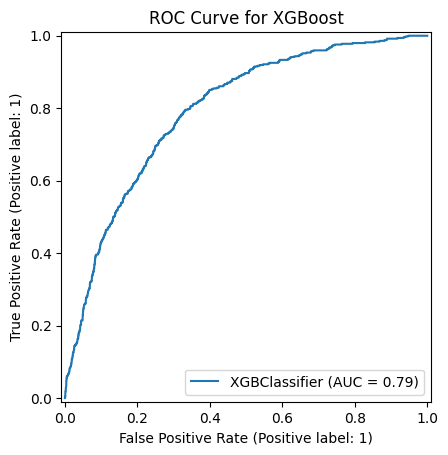

ROC Curve plot saved as 'roc_curve.png'.


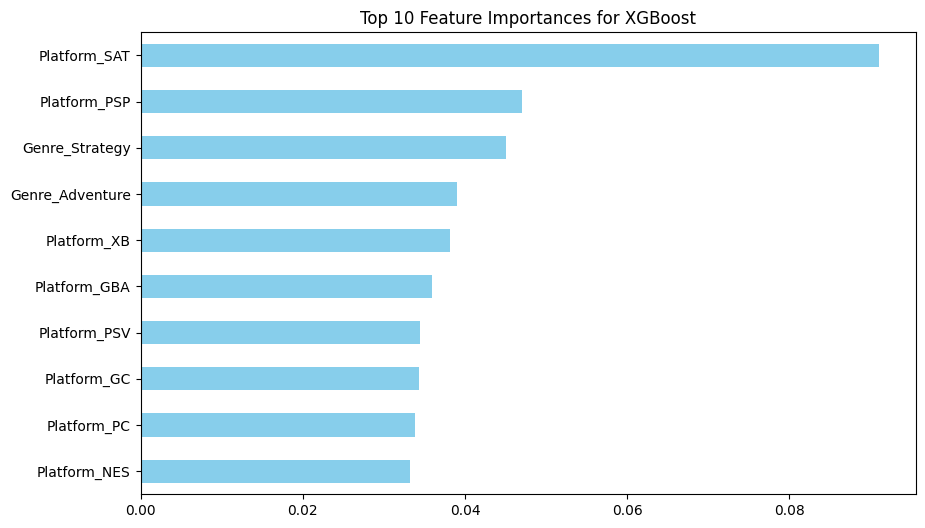

Feature Importance plot saved as 'feature_importance.png'.


In [12]:
# --- 7. VISUALIZATION GENERATION (For Best Model) ---

if best_y_pred is not None:
    # A. Confusion Matrix Plot (Required for Report)
    cm = confusion_matrix(y_test, best_y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Flop (0)', 'Hit (1)'], 
                yticklabels=['Flop (0)', 'Hit (1)'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {best_model_name}')
    plt.savefig('confusion_matrix.png')
    plt.show()
    plt.close()
    print("\nConfusion Matrix plot saved as 'confusion_matrix.png'.")
    

    # B. ROC Curve Plot (Highly Recommended)
    if hasattr(models_to_evaluate[best_model_name], 'predict_proba'):
        plt.figure(figsize=(8, 6))
        # Ensure the best model is available for RocCurveDisplay
        RocCurveDisplay.from_estimator(models_to_evaluate[best_model_name], X_test, y_test)
        plt.title(f'ROC Curve for {best_model_name}')
        plt.savefig('roc_curve.png')
        plt.show()
        plt.close()
        print("ROC Curve plot saved as 'roc_curve.png'.")
        


    # C. Feature Importance Plot (Essential for Tree-Based Models)
    if best_model_name in ["Random Forest", "XGBoost"] and models_to_evaluate[best_model_name] is not None:
        try:
            # Use feature_importances_ for both RF and XGBoost (due to Scikit-learn wrapper)
            feature_importances = pd.Series(models_to_evaluate[best_model_name].feature_importances_, index=X.columns)
            top_10_features = feature_importances.nlargest(10)
            
            plt.figure(figsize=(10, 6))
            top_10_features.plot(kind='barh', color='skyblue')
            plt.title(f'Top 10 Feature Importances for {best_model_name}')
            plt.gca().invert_yaxis()
            plt.savefig('feature_importance.png')
            plt.show()
            plt.close()
            print("Feature Importance plot saved as 'feature_importance.png'.")
            
        except AttributeError:
            print(f"\nFeature importance plot skipped: {best_model_name} does not have feature_importances_ attribute.")

else:
    print("\nCannot generate plots because no valid model was trained or evaluated.")

# --- END OF SCRIPT ---